In [15]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from statsmodels.stats.proportion import proportions_chisquare_allpairs, proportions_ztest
from statsmodels.stats.multitest import multipletests
from collections import Counter
from wordcloud import WordCloud
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.font_manager as fm
import json
from pyvis.network import Network
import networkx as nx
import gzip
# from sklearn.metrics import cohen_kappa_score
# import random
# pd.options.display.max_columns=150
# pd.set_option('display.max_colwidth', None)

In [3]:
# Define a function to convert strings to tuples
def convert_to_tuple(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return value

# Load data from train, validation and test sets

In [4]:
# Load data
df = pd.concat([pd.read_csv('datasets/train_val_test_sets/df_train.csv'),
                            pd.read_csv('datasets/train_val_test_sets/df_val.csv'),
                            pd.read_csv('datasets/train_val_test_sets/df_test.csv')])
# Corrections due to characteristics lost in the csv files
df['new_id'] = df['new_id'].astype('string')

# Apply the function to the column containing string representations of tuples
df['hashtags'] = df['hashtags'].apply(convert_to_tuple)
df['mentions'] = df['mentions'].apply(convert_to_tuple)

fallacy_names = ['Ad Hominem', 'Appeal to Fear', 'Appeal to Ridicule', 'False Dilemma', 'Hasty Generalization', 'Loaded Language', 'None of the above']

# General Statistics

Percent of tweets that contain the fallacy
None of the above       65.397805
Loaded Language         15.672154
Ad Hominem               8.882030
Appeal to Ridicule       8.161866
False Dilemma            5.761317
Appeal to Fear           5.384088
Hasty Generalization     3.120713
dtype: float64
Absolute number of tweets that contain the fallacy
None of the above       1907
Loaded Language          457
Ad Hominem               259
Appeal to Ridicule       238
False Dilemma            168
Appeal to Fear           157
Hasty Generalization      91
dtype: int64


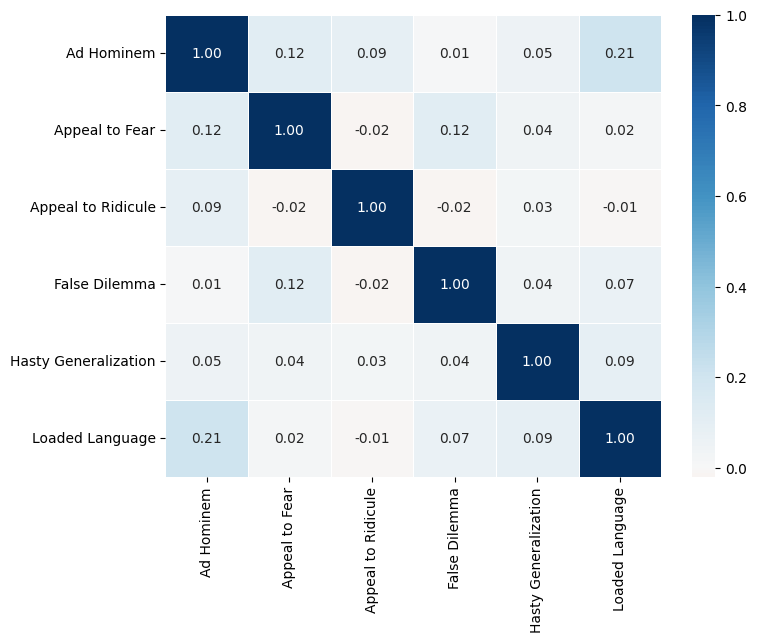

In [5]:
print('Percent of tweets that contain the fallacy')
print((df[fallacy_names].mean()*100).sort_values(ascending=False))

print('Absolute number of tweets that contain the fallacy')
print((df[fallacy_names].sum()).sort_values(ascending=False))

df_just_fallacies = df[fallacy_names].drop(columns='None of the above')

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_just_fallacies.corr(), annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5, center=0)
# plt.title('Correlation among fallacies')
plt.savefig("img/correlation_heatmap.pdf", format='pdf', bbox_inches='tight')
plt.show()

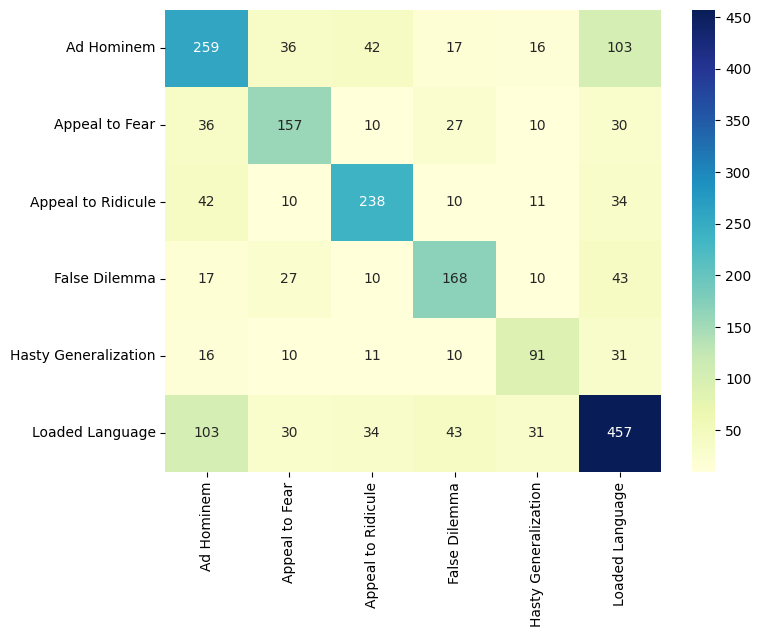

In [6]:
# Compute the co-occurrence matrix
co_occurrence_matrix = np.dot(df_just_fallacies.T, df_just_fallacies)

# Create a DataFrame for the co-occurrence matrix
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=df_just_fallacies.columns, columns=df_just_fallacies.columns)

# Plot a heatmap using seaborn for the co-occurrence matrix
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_df, annot=True, cmap='YlGnBu', fmt=".0f")
# plt.title('Co-occurrence matrix of fallacies')
plt.savefig("img/co_occurrence_heatmap.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Number of fallacies by tweet

In [7]:
# Number of tweets by fallacy count
df['total_fallacies'] = df[[x for x in fallacy_names if x != 'None of the above']].sum(axis=1)
df['total_fallacies'].value_counts()

total_fallacies
0    1907
1     708
2     250
3      42
4       9
Name: count, dtype: int64

# The Graph

In [14]:
G_modified_with_attributes = pickle.load(open('results/G_modified_with_attributes.pkl', 'rb'))
G_sample = G_modified_with_attributes.subgraph(df['new_id'].values)
print('Number of nodes:',G_sample.number_of_nodes())
print('Number of arcs:',G_sample.number_of_edges())

Number of nodes: 2916
Number of arcs: 1506


In [16]:
# Save the graph
pickle.dump(G_sample, open('results/G_dataset_sample_with_attributes.pkl', 'wb'))

# Convert pandas.Timestamp to Unix time (integer). This is necessary to save the graph as a graphml file
def convert_timestamp_to_unix(graph):
    for node, data in graph.nodes(data=True):
        for attr, value in data.items():
            if isinstance(value, pd.Timestamp):
                data[attr] = value.timestamp()  # Convert to Unix time

    for u, v, data in graph.edges(data=True):
        for attr, value in data.items():
            if isinstance(value, pd.Timestamp):
                data[attr] = value.timestamp()  # Convert to Unix time

# Apply the conversion to the graph G
convert_timestamp_to_unix(G_sample)

# Save the graph directly as a GZIP compressed GraphML file (good for portability)
with gzip.open("results/G_dataset_sample_with_attributes.graphml.gz", "wb") as f:
    nx.write_graphml(G_sample, f)

In [21]:
# Visualizing the graph
# Initialize the pyvis network
net = Network(notebook=True, bgcolor='#222222', width="100%", height="800px", font_color='white')

# Convert NetworkX graph to pyvis network
net.from_nx(G_sample)

# Save the visualization as an HTML file
net.save_graph("results/graph_visualizations/G_dataset.html")

# Fallacy transition in coversations

In this section we observe the relationship between fallacies (or the lack of them) in our graph of tweets. When you have a node that contains a particular fallacy, the function analyzes the network structure to determine what fallacies are present in the nodes connected to it. For instance, from the data we can see that if a tweet contains an Ad Hominem attack, the replies to that tweet are most likely to contain another Ad Hominem fallacy or Loaded Language, rather than a False Dilemma fallacy. 



In [51]:
def analyze_pairs_of_fallacies(df_edges, df_nodes, node_id):
    """
    Analyzes pairs of fallacies in a network of nodes and edges.

    Args:
    - df_edges (DataFrame): DataFrame containing information about edges.
    - df_nodes (DataFrame): DataFrame containing information about nodes and its fallacies.
    - node_id (str): Name of the column in df_nodes that contains the node IDs.

    Returns:
    None
    """
    # Unpivot the DataFrame to have a long format
    df_nodes_melted = pd.melt(df_nodes, id_vars=[node_id], var_name='fallacy', value_name='value')

    # Filter out rows where value is 1
    df_nodes_melted = df_nodes_melted[df_nodes_melted['value'] == 1]

    # Drop the value column as it's no longer needed
    df_nodes_melted.drop(columns='value', inplace=True)

    # Merge edges DataFrame with nodes DataFrame based on source node
    # Rename columns for clarity and drop unnecessary columns
    df_pairs_of_fallacies = df_edges.merge(df_nodes_melted, left_on='source', right_on=node_id, how='left') \
        .rename(columns={'fallacy': 'fallacy_source'}, inplace=False) \
        .merge(df_nodes_melted, left_on='destination', right_on=node_id, how='left') \
        .rename(columns={'fallacy': 'fallacy_destination'}, inplace=False) #\
        # .drop(columns=['node_id_x', 'node_id_y'])

    # Calculate absolute number of pairs of fallacies
    crosstab_absolute = pd.crosstab(df_pairs_of_fallacies['fallacy_source'], df_pairs_of_fallacies['fallacy_destination'])

    # Calculate percent of pairs of fallacies in relation to the total number of pairs
    crosstab_total_percent = pd.crosstab(df_pairs_of_fallacies['fallacy_source'], df_pairs_of_fallacies['fallacy_destination'], normalize='all')*100

    # Calculate percent of pairs of fallacies in relation to the source fallacy
    crosstab_source_percent = pd.crosstab(df_pairs_of_fallacies['fallacy_source'], df_pairs_of_fallacies['fallacy_destination'], normalize='index')*100

    # Display heatmaps
    # plt.figure(figsize=(14, 6))
    # plt.subplot(1, 3, 1)
    sns.heatmap(crosstab_absolute, annot=True, cmap="YlGnBu", fmt='d')
    plt.title('Absolute number of pairs of fallacies')
    plt.xlabel('Following tweet (out-neighbor)')
    plt.ylabel('Main tweet')
    plt.show()
    # plt.subplot(1, 3, 2)
    sns.heatmap(crosstab_total_percent, annot=True, cmap="YlGnBu", fmt='.2f')
    plt.title('Percent of pairs of fallacies (in relation to the total number of pairs)')
    plt.xlabel('Following tweet (out-neighbor)')
    plt.ylabel('Main tweet')
    plt.show()
    # plt.subplot(1, 3, 3)
    sns.heatmap(crosstab_source_percent, annot=True, cmap="YlGnBu", fmt='.2f')
    # plt.title('Percent of reply tweets that contain each fallacy (by fallacy type of the main tweet)')
    plt.xlabel('Destination tweet')
    plt.ylabel('Source tweet (Main tweet)')
    # plt.tight_layout()
    plt.savefig("img/conditional_prob_matrix.pdf", format='pdf', bbox_inches='tight')
    plt.show()

    return crosstab_absolute, crosstab_total_percent, crosstab_source_percent



**By fallacy types**

In [7]:
# Load complete graph of tweets
G = pickle.load(open("results/G.pkl", "rb"))
# Get subgraph of annotated nodes
G_sub = G.subgraph(df['new_id'].tolist())
# Get edges of the subgraph
edges = G_sub.edges()
# Dataframe with edges
df_edges = pd.DataFrame(edges, columns=['source', 'destination'])
df_edges

,source,destination
0,118718,120131
1,182683,212370
2,273405,91403
3,168021,344583
4,157507,74008
...,...,...
1501,271358,283970
1502,271358,309564
1503,42666,42663
1504,33392,123597


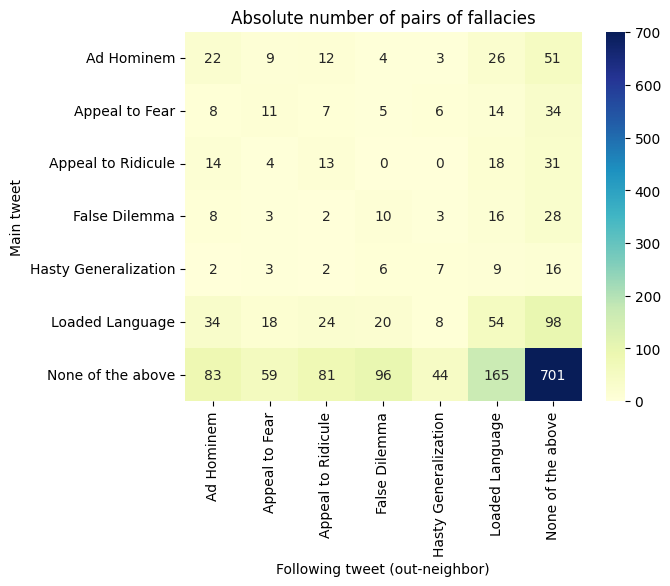

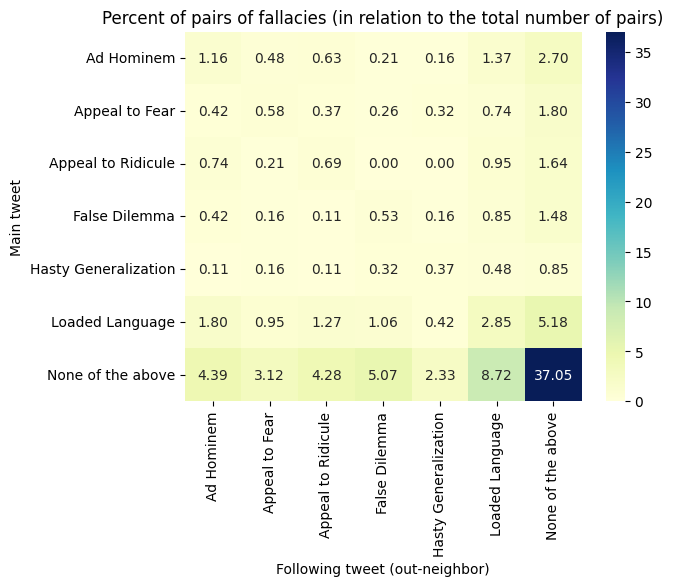

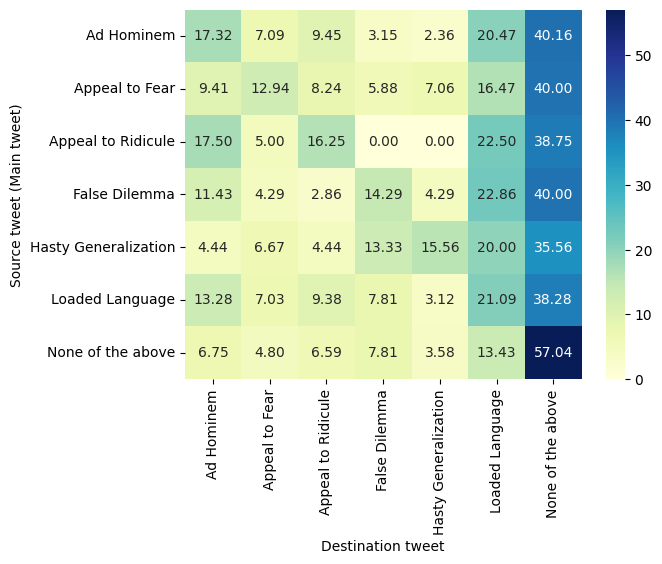

(fallacy_destination   Ad Hominem  Appeal to Fear  Appeal to Ridicule   
 fallacy_source                                                         
 Ad Hominem                    22               9                  12  \
 Appeal to Fear                 8              11                   7   
 Appeal to Ridicule            14               4                  13   
 False Dilemma                  8               3                   2   
 Hasty Generalization           2               3                   2   
 Loaded Language               34              18                  24   
 None of the above             83              59                  81   
 
 fallacy_destination   False Dilemma  Hasty Generalization  Loaded Language   
 fallacy_source                                                               
 Ad Hominem                        4                     3               26  \
 Appeal to Fear                    5                     6               14   
 Appeal to Ridicule      

In [52]:
analyze_pairs_of_fallacies(df_edges = df_edges, df_nodes = df[['new_id'] + fallacy_names], node_id = 'new_id')

**By fallacious or non-fallacious**

/tmp/ipykernel_403061/1581807216.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodes_info['Fallacious'] = 1 - df_nodes_info['None of the above']
/tmp/ipykernel_403061/1581807216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodes_info.rename(columns={'None of the above': 'Non-fallacious'}, inplace=True)


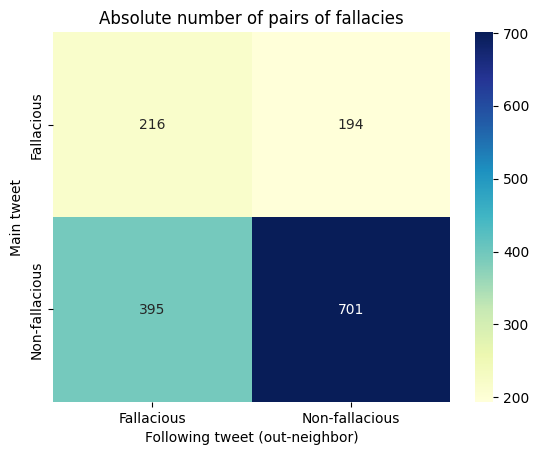

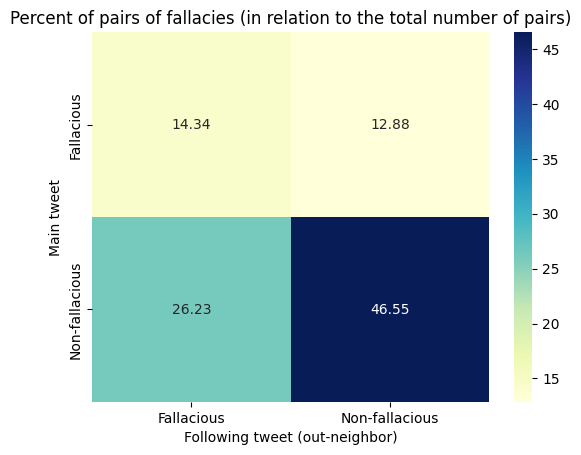

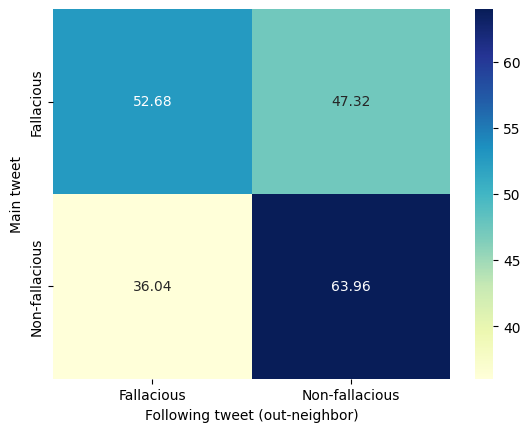

In [9]:
df_nodes_info = df[['new_id', 'None of the above']]
# Create column called Fallacious that is the negation of None of the above
df_nodes_info['Fallacious'] = 1 - df_nodes_info['None of the above']
# Rename None of the above to Non-fallacious
df_nodes_info.rename(columns={'None of the above': 'Non-fallacious'}, inplace=True)

df_fallacious_reply_by_fallacy_or_not_in_source, _, _ = analyze_pairs_of_fallacies(df_edges = df_edges, df_nodes = df_nodes_info, node_id = 'new_id')

**Is a tweet with a particular fallacy type more proponse to be followed by fallacious tweets?**

We can see that for the tweets that contained a Hasty Generalization fallacy, 64.4% of the replies contained at least one of the fallacies we are studying. Respectively this numbers are 0.61.7 for Loaded Language, 61.2 for Appeal to Ridicule, 60% for Appeal to Fear and False Dilemma, and 59.8 for Ad Hominem.We can contrast this number to the rather low 42.9% for None of the above. 

We performed a Chi-square test of proportions for all pairs of fallacy types and the None of the above category. We use Bonferroni adjustment.
The test reveal that the only pairs in which we can assume a true difference in the proporsions are Ad Hominem vs None of the Above, Appeal to Fear vs None of the above, Appeal to Ridicule vs None of the above, and Loaded Language vs None of the Above. That is, in this cases there is enough statiscal evidence to claim that: the proportion reply tweet that contain a fallacy is different between Ad Hominem vs None of the Above, Appeal to Fear vs None of the above, Appeal to Ridicule vs None of the above.  

We also apply a one-sided Z test for proportions to examine if the proportion of fallacious replies is greater than random chance (i.e. greater than 0.5) for each of the fallacy types. There are significant results only for Loaded Language. This results indicate that it is more likely to great a fallacious tweet as a reply to a tweet that contains a Loaded Language fallacy.    


In [10]:
# Table for proportions analysis

# Get relevant columns
df_nodes = df[['new_id'] + fallacy_names]

# Unpivot the DataFrame to have a long format
df_nodes_melted = pd.melt(df_nodes, id_vars=['new_id'], var_name='fallacy', value_name='value')

# Filter out rows where value is 1
df_nodes_melted = df_nodes_melted[df_nodes_melted['value'] == 1]

# Drop the value column as it's no longer needed
df_nodes_melted.drop(columns='value', inplace=True)

# Binary column for fallacious or non-fallacious
df_nodes_melted['is_fallacious'] = (df_nodes_melted['fallacy'] != 'None of the above').astype(int)

# Dataframe with edges and fallacies (both types and binary)
df_proportion_fallacious_reply_by_fallacy_in_source = df_edges.merge(df_nodes_melted[['new_id','fallacy']], left_on='source', right_on='new_id', how='left') \
    .merge(df_nodes_melted[['new_id','is_fallacious']], left_on='destination', right_on='new_id', how='left') \
    .rename(columns={'fallacy': 'fallacy_source','is_fallacious': 'is_fallacious_destination'}, inplace=False) \
    .drop(columns=['new_id_x', 'new_id_y']) \
    .groupby(['fallacy_source'])['is_fallacious_destination'].agg(['sum','count']) \
    .reset_index() \
    .rename(columns={'sum': 'fallacious_counts_in_destination', 'count': 'total_counts'})

# Calculate proportion of fallacious replies by fallacy in source
df_proportion_fallacious_reply_by_fallacy_in_source['proportion'] = df_proportion_fallacious_reply_by_fallacy_in_source['fallacious_counts_in_destination'] / df_proportion_fallacious_reply_by_fallacy_in_source['total_counts']
df_proportion_fallacious_reply_by_fallacy_in_source.sort_values(by='proportion', ascending=False)

,fallacy_source,fallacious_counts_in_destination,total_counts,proportion
4,Hasty Generalization,29,45,0.644444
5,Loaded Language,158,256,0.617188
2,Appeal to Ridicule,49,80,0.612500
1,Appeal to Fear,51,85,0.600000
3,False Dilemma,42,70,0.600000
0,Ad Hominem,76,127,0.598425
6,None of the above,528,1229,0.429618


In [11]:
# Perform chi-square test for proportions
results_proportions_test = proportions_chisquare_allpairs(count = df_proportion_fallacious_reply_by_fallacy_in_source['fallacious_counts_in_destination'],
                                         nobs = df_proportion_fallacious_reply_by_fallacy_in_source['total_counts'],
                                         multitest_method='b')

# Function to convert tuple elements to the corresponding names
def convert_tuple(t, mapping):
  return tuple(mapping[i] for i in t)

# Convert tuples of integers to fallacy names
pairs = [convert_tuple(t, df_proportion_fallacious_reply_by_fallacy_in_source['fallacy_source']) for t in results_proportions_test.all_pairs]

df_proportions_test_results = pd.DataFrame({'pair': pairs, 'p-value': results_proportions_test.pval_corrected()})
df_proportions_test_results['reject_null'] = df_proportions_test_results['p-value'] < 0.05

pd.options.display.max_columns=25
df_proportions_test_results

,pair,p-value,reject_null
0,"(Ad Hominem, Appeal to Fear)",1.000000e+00,False
1,"(Ad Hominem, Appeal to Ridicule)",1.000000e+00,False
2,"(Ad Hominem, False Dilemma)",1.000000e+00,False
3,"(Ad Hominem, Hasty Generalization)",1.000000e+00,False
4,"(Ad Hominem, Loaded Language)",1.000000e+00,False
5,"(Ad Hominem, None of the above)",5.638216e-03,True
6,"(Appeal to Fear, Appeal to Ridicule)",1.000000e+00,False
7,"(Appeal to Fear, False Dilemma)",1.000000e+00,False
8,"(Appeal to Fear, Hasty Generalization)",1.000000e+00,False
9,"(Appeal to Fear, Loaded Language)",1.000000e+00,False


In [12]:
# Perform z-test for proportions (just to verify that both tests agree)

def z_test_proportions_all_pairs(data, group, successes, trials):

  """
  This function performs pairwise z-tests for proportions and returns p-values adjusted for multiple comparisons using the Bonferroni method.

  Args:
      data (pandas.DataFrame): The DataFrame containing the data for analysis.
      group (str): The name of the column in the DataFrame that specifies the group.
      successes (str): The name of the column in the DataFrame that contains the number of successes for each group.
      trials (str): The name of the column in the DataFrame that contains the total number of trials for each group.

  Returns:
      tuple: A tuple containing the results of multiple tests function.
          - The first element is an array of booleans indicating rejection (True) or non-rejection (False) based on a significance level.
          - The second element is the adjusted p-values for each pairwise comparison.
  """

  # List to store p-values
  p_values = []

  # Get all group combinations
  from itertools import combinations
  group_combs = combinations(data[group], 2)

  # Perform tests
  for group1, group2 in group_combs:
    # Extract data for each group
    group1_data = data.loc[data[group] == group1]
    group2_data = data.loc[data[group] == group2]

    # Proportion test with z-test
    _, pval = proportions_ztest(count=[group1_data[successes].iloc[0], group2_data[successes].iloc[0]],
                                         nobs=[group1_data[trials].iloc[0], group2_data[trials].iloc[0]])
    p_values.append(pval)

  # Adjust p-values for multiple comparisons
  return multipletests(p_values, method='Bonferroni')  # Adjust using Bonferroni

z_test_proportions_all_pairs(data = df_proportion_fallacious_reply_by_fallacy_in_source,
                             group = 'fallacy_source',
                             successes = 'fallacious_counts_in_destination',
                             trials = 'total_counts')

(array([False, False, False, False, False,  True, False, False, False,
        False,  True, False, False, False,  True, False, False, False,
        False, False,  True]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 5.63821620e-03, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 4.64769373e-02, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 2.96286229e-02, 1.00000000e+00,
        1.00000000e+00, 1.09268863e-01, 1.00000000e+00, 9.08230252e-02,
        9.12074425e-07]),
 0.002439557259668823,
 0.002380952380952381)

In [13]:
def z_test_proportions_one_tailed_by_group(data, group, successes, trials):
  """
  This function performs one-tailed z-tests for proportions on a pandas DataFrame
  and returns p-values adjusted for multiple comparisons using the Bonferroni method.
  The null hypothesis is p = 0.5, and the alternative hypothesis is p > 0.5.

  Args:
      data (pandas.DataFrame): The DataFrame containing the data for analysis.
      group (str): The name of the column in the DataFrame that specifies the group membership.
      successes (str): The name of the column in the DataFrame that contains the number of successes for each group.
      trials (str): The name of the column in the DataFrame that contains the total number of trials for each group.

  Returns:
      tuple: A tuple containing the results of multiple tests function.
          - The first element is an array of booleans indicating rejection (True) or non-rejection (False) based on a significance level.
          - The second element is the adjusted p-values for each one-tailed z-test.
  """

  p_values = []
  for group_name in data[group].unique():
    # Extract data for the group
    group_data = data.loc[data[group] == group_name]

    # Proportion test with z-test (one-tailed)
    z_stat, pval = proportions_ztest(count=group_data[successes].iloc[0],
                                     nobs=group_data[trials].iloc[0],
                                     value=0.5,
                                     alternative='larger')
    p_values.append(pval)

  # Adjust p-values for multiple comparisons (Bonferroni)
  rejections, adjusted_pvals, _, _ = multipletests(p_values, method='bonferroni')

  # Create results dictionary
  results = {
    "group": data[group].unique(),
    "rejected": rejections,
    "p_value": adjusted_pvals
  }

  # Create DataFrame
  return pd.DataFrame(results)

z_test_proportions_one_tailed_by_group(data = df_proportion_fallacious_reply_by_fallacy_in_source,
                                       group = 'fallacy_source',
                                       successes = 'fallacious_counts_in_destination',
                                       trials = 'total_counts')

,group,rejected,p_value
0,Ad Hominem,False,0.082798
1,Appeal to Fear,False,0.209459
2,Appeal to Ridicule,False,0.136091
3,False Dilemma,False,0.306841
4,Hasty Generalization,False,0.150311
5,Loaded Language,True,0.000401
6,None of the above,False,1.000000


In most of the cases we do not reject the null hypothesis, but this could be due to the small sample size for some groups. When sample size is small, the power of the test diminishes. 

Let's do some testing with groups that contain more sample size. We now compare 2 groups only: Fallacious vs non-fallacious tweets. We suspect that fallacious tweets get more fallacious replies. So we compare the proportion of replies that contain a fallacy between the 2 groups. We use a one-tailed z test of proportions. This statistical test indicates that there is enought evidence to assume that the proportion of fallacious reply tweets is larger of fallacious tweets, than for non-fallacious. 

In [14]:
df_fallacious_reply_by_fallacy_or_not_in_source.reset_index(inplace=True)
zstat, p_value = proportions_ztest(count = df_fallacious_reply_by_fallacy_or_not_in_source['Fallacious'],
                                   nobs = df_fallacious_reply_by_fallacy_or_not_in_source['Non-fallacious'] + df_fallacious_reply_by_fallacy_or_not_in_source['Fallacious'],
                                   alternative='larger')
print('H0: p_fallacious = p_non_fallacious')
print('H1: p_fallacious > p_non_fallacious')
print(p_value)
print('Reject null hipothesis', p_value < 0.05)


H0: p_fallacious = p_non_fallacious
H1: p_fallacious > p_non_fallacious
2.389588507275355e-09
Reject null hipothesis True


# Hashtags, mentions and emojis descriptive analysis

In [15]:
# General functions for analysis

# Function to convert elements in a tuple to lower case and keep only letters and numbers
def to_lower_case_and_alnum(tup):
    return tuple(re.sub(r'[^a-zA-Z0-9]', '', hashtag).lower() for hashtag in tup)

def get_frequencies_from_tuples(df, column_name, wordcloud=True):
    """
    This function takes a DataFrame and a column name containing tuples and returns a DataFrame with the frequency of each element in the tuples.

    Args:
    - df (DataFrame): The DataFrame containing the column with tuples.
    - column_name (str): The name of the column containing the tuples.

    Returns:
    DataFrame: A DataFrame with the frequency of each element in the tuples.
    """
    # Flatten the list of tuples into a single list of elements
    all_elements = [element for sublist in df[column_name] for element in sublist]

    # Count the frequency of each element
    elements_counts = Counter(all_elements)

    # Convert to a DataFrame for easier manipulation and visualization
    freq_df = pd.DataFrame(elements_counts.items(), columns=[column_name, 'frequency'])

    if wordcloud:
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(elements_counts)

        # Plot the word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        # plt.title('Frequency of ' + column_name)
        plt.show()

    return freq_df

def get_elements_in_top_percentile(freq_df, column_name, percentile):
    '''
    This function takes a DataFrame with the frequency of each element in the tuples and returns a list of elements that are in the top percentile.
    '''

    freq_df = freq_df.sort_values(by='frequency', ascending=False)
    freq_df['cumulative_frequency'] = freq_df['frequency'].cumsum()
    freq_df['cumulative_percentage'] = freq_df['cumulative_frequency'] / freq_df['frequency'].sum() * 100
    return list(freq_df[column_name][freq_df['cumulative_percentage'] <= percentile])

def get_tfidf_from_tuples_by_fallacy_type(df, column_name, fallacy_names, frequency_threshold, top_n = 10):
    """
    This function computes and visualizes the TF-IDF (Term Frequency-Inverse Document Frequency) scores of elements within tuples in a specified column of a DataFrame, categorized by fallacy types. The TF-IDF score reflects the importance of elements in documents relative to a collection of documents, where each document corresponds to a fallacy type.

    Specifically, the function:
    - Constructs documents for each fallacy type from the tuples in the specified column.
    - Computes the TF-IDF scores for elements within these documents.
    - Filters elements that meet or exceed a specified frequency threshold.
    - Identifies and visualizes the top and bottom n elements based on their TF-IDF scores.

    Args:
    - df (DataFrame): The DataFrame containing the column with tuples.
    - column_name (str): The name of the column containing the tuples.
    - fallacy_names (list): The list of columns representing different fallacy types.
    - frequency_threshold (int): The minimum frequency an element must have to be included.
    - top_n (int, optional): The number of top and bottom elements to visualize. Defaults to 10.

    Returns:
    DataFrame: A DataFrame containing the TF-IDF scores of elements within the tuples, categorized by fallacy type.

    Additionally, the function creates a heatmap of the TF-IDF scores for the top and bottom elements by fallacy type.
    """

    # Create a dictionary to store documents for each fallacy type
    fallacy_docs = defaultdict(list)

    # Iterate through each row to construct documents for each fallacy type
    for _, row in df.iterrows():
        for fallacy_type in fallacy_names:
            if row[fallacy_type] == 1:
                fallacy_docs[fallacy_type].extend(row[column_name])

    # Convert lists to strings as required by TfidfVectorizer
    fallacy_docs = {key: ' '.join(hashtags) for key, hashtags in fallacy_docs.items()}

    # TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(fallacy_docs.values())

    # Create a DataFrame to display the TF-IDF scores
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=fallacy_docs.keys(), columns=vectorizer.get_feature_names_out())

    # Filter elements that appear more than 5 times
    freq_df = get_frequencies_from_tuples(df, column_name, wordcloud=False)
    filtered_tfidf_df = tfidf_df[list(freq_df[column_name][freq_df['frequency'] >= frequency_threshold])]

    # # Get the top elements for each fallacy type based on TF-IDF scores
    # top_elements = {}
    # for fallacy_type in tfidf_df.index:
    #     top_elements[fallacy_type] = tfidf_df.loc[fallacy_type].nlargest(top_n).index.tolist()

    # # Collect all unique hashtags from the top n lists
    # unique_elements = set()
    # for elements in top_elements.values():
    #     unique_elements.update(elements)

    # Get the top most and least fallacious elements based on TF-IDF scores
    top_elements = filtered_tfidf_df.loc['None of the above'].nlargest(top_n).index.tolist()
    bottom_elements = filtered_tfidf_df.loc['None of the above'].nsmallest(top_n).index.tolist()
    unique_elements = set(top_elements + bottom_elements)

    # Filter the TF-IDF DataFrame to include only the top elements
    filtered_tfidf_df = filtered_tfidf_df[list(unique_elements)].T

    # Create the heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(filtered_tfidf_df.sort_values(by='None of the above', ascending=True), annot=True, cmap='Blues')
    plt.title('TF-IDF Heatmap for Top ' + str(top_n) +' '+ column_name + ' by Fallacy Type')
    plt.xlabel('Fallacy Types')
    plt.ylabel(column_name)
    plt.show()

    return tfidf_df


def get_frequency_matrix_by_fallacy(df, column_name, fallacy_names, frequency_threshold, top_n=10):

    """
    This function computes and visualizes the frequency of elements within a specified column of a DataFrame, categorized by fallacy types. It returns both absolute and relative frequency matrices and visualizes the relative frequencies of the top and bottom `n` elements based on their association with a particular fallacy type.

    Specifically, the function:
    - Initializes a frequency matrix for elements and fallacy types.
    - Iterates through each row in the DataFrame to populate the frequency matrix based on the presence of fallacies.
    - Normalizes the frequency matrix to compute relative frequencies.
    - Filters elements that meet or exceed a specified frequency threshold.
    - Identifies and visualizes the top and bottom `n` elements based on their relative frequencies.

    Args:
    - df (DataFrame): The DataFrame containing the column with elements (e.g., hashtags).
    - column_name (str): The name of the column containing the elements (e.g., a list of hashtags).
    - fallacy_names (list): The list of columns representing different fallacy types.
    - frequency_threshold (int): The minimum frequency an element must have to be included.
    - top_n (int, optional): The number of top and bottom elements to visualize. Defaults to 10.

    Returns:
    Tuple[DataFrame, DataFrame]: A tuple containing two DataFrames:
        - absolute_freq_df: A DataFrame with the absolute frequencies of elements by fallacy type.
        - relative_freq_df: A DataFrame with the relative frequencies of elements by fallacy type.

    Additionally, the function creates a heatmap of the relative frequencies for the top and bottom elements by fallacy type.
    """


    # Initialize a DataFrame with elements as the index and fallacy names as columns, filled with zeros
    freq_df = get_frequencies_from_tuples(df, column_name, wordcloud=False)
    element_fallacy = pd.DataFrame(index=freq_df[column_name], columns=fallacy_names).fillna(0)

    # Iterate over each row in the DataFrame df
    for idx, row in df.iterrows():
        # Iterate over each element in the current row's column_name list
        for element in row[column_name]:
            # Iterate over each fallacy name
            for fallacy in fallacy_names:
                # If the current row indicates the presence of the fallacy (value is 1)
                if row[fallacy] == 1:
                    # Increment the count of the fallacy for the element in the correlation matrix
                    element_fallacy.at[element, fallacy] += 1

    # Normalize the element_fallacy DataFrame by dividing each value by the frequency of the corresponding element
    absolute_freq_df = element_fallacy
    relative_freq_df = element_fallacy.div(freq_df.set_index(column_name)['frequency'], axis=0)

    # Filter out hashtags that appear less than 5 times
    filtered_relative_freq_df = relative_freq_df.loc[list(freq_df[column_name][freq_df['frequency'] >= frequency_threshold])]

    # # Filter the DataFrame to include only the top n hashtags for each fallacy
    # top_elements_set = set([element for sublist in [filtered_relative_freq_df[fallacy].nlargest(top_n).index.tolist() for fallacy in fallacy_names] for element in sublist])
    # filtered_relative_freq_df = filtered_relative_freq_df.loc[list(top_elements_set)]
    # filtered_relative_freq_df.sort_values(by='None of the above', ascending=False, inplace=True)

    # Filter the DataFrame to include only the top n more and less fallacious hashtags
    top_elements = filtered_relative_freq_df['None of the above'].nlargest(top_n).index.tolist()
    bottom_elements = filtered_relative_freq_df['None of the above'].nsmallest(top_n).index.tolist()
    filtered_relative_freq_df = filtered_relative_freq_df.loc[list(set(top_elements + bottom_elements))]
    filtered_relative_freq_df.sort_values(by='None of the above', ascending=True, inplace=True)


    # Set the size of the figure for the heatmap
    plt.figure(figsize=(20, 10))
    # Create a heatmap to visualize the correlation between top hashtags and fallacies
    sns.heatmap(filtered_relative_freq_df, annot=True, cmap='Blues')
    plt.title('Relative frequency for Top ' + str(top_n) +' '+ column_name + ' by Fallacy Type')
    # Display the heatmap
    plt.show()

    return absolute_freq_df, relative_freq_df


## Hashtags

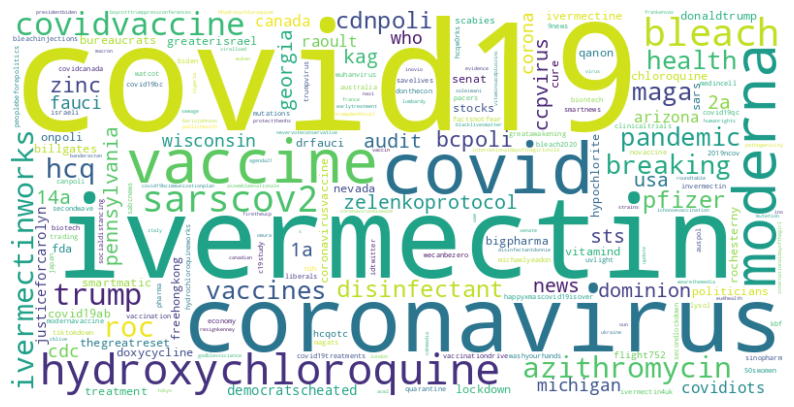

               hashtags  frequency
14              covid19        261
11           ivermectin        132
61          coronavirus         79
54                covid         44
68              vaccine         31
114             moderna         29
12   hydroxychloroquine         28
58               bleach         22
75             sarscov2         21
220        covidvaccine         15
204               trump         13
13         azithromycin         12
170     ivermectinworks         12
534                 roc         11
15                  hcq         10
80             breaking          9
30               health          8
71             pandemic          8
146                maga          8
150            vaccines          8
40              cdnpoli          7
136              pfizer          7
244        disinfectant          7
31               bcpoli          6
64                 zinc          6


In [16]:
df['hashtags'] = df['hashtags'].apply(to_lower_case_and_alnum)

hashtag_freq_df = get_frequencies_from_tuples(df, 'hashtags', wordcloud=True)

# Get the top most frequent hashtags
top_hashtags = hashtag_freq_df.nlargest(25, 'frequency')
print(top_hashtags)

In [17]:
selected_hashtags = list(hashtag_freq_df['hashtags'][hashtag_freq_df['frequency'] > 5])

In [18]:
get_elements_in_top_percentile(hashtag_freq_df, 'hashtags', 45)

['covid19',
 'ivermectin',
 'coronavirus',
 'covid',
 'vaccine',
 'moderna',
 'hydroxychloroquine',
 'bleach',
 'sarscov2',
 'covidvaccine',
 'trump',
 'azithromycin',
 'ivermectinworks',
 'roc',
 'hcq',
 'breaking',
 'health',
 'maga']

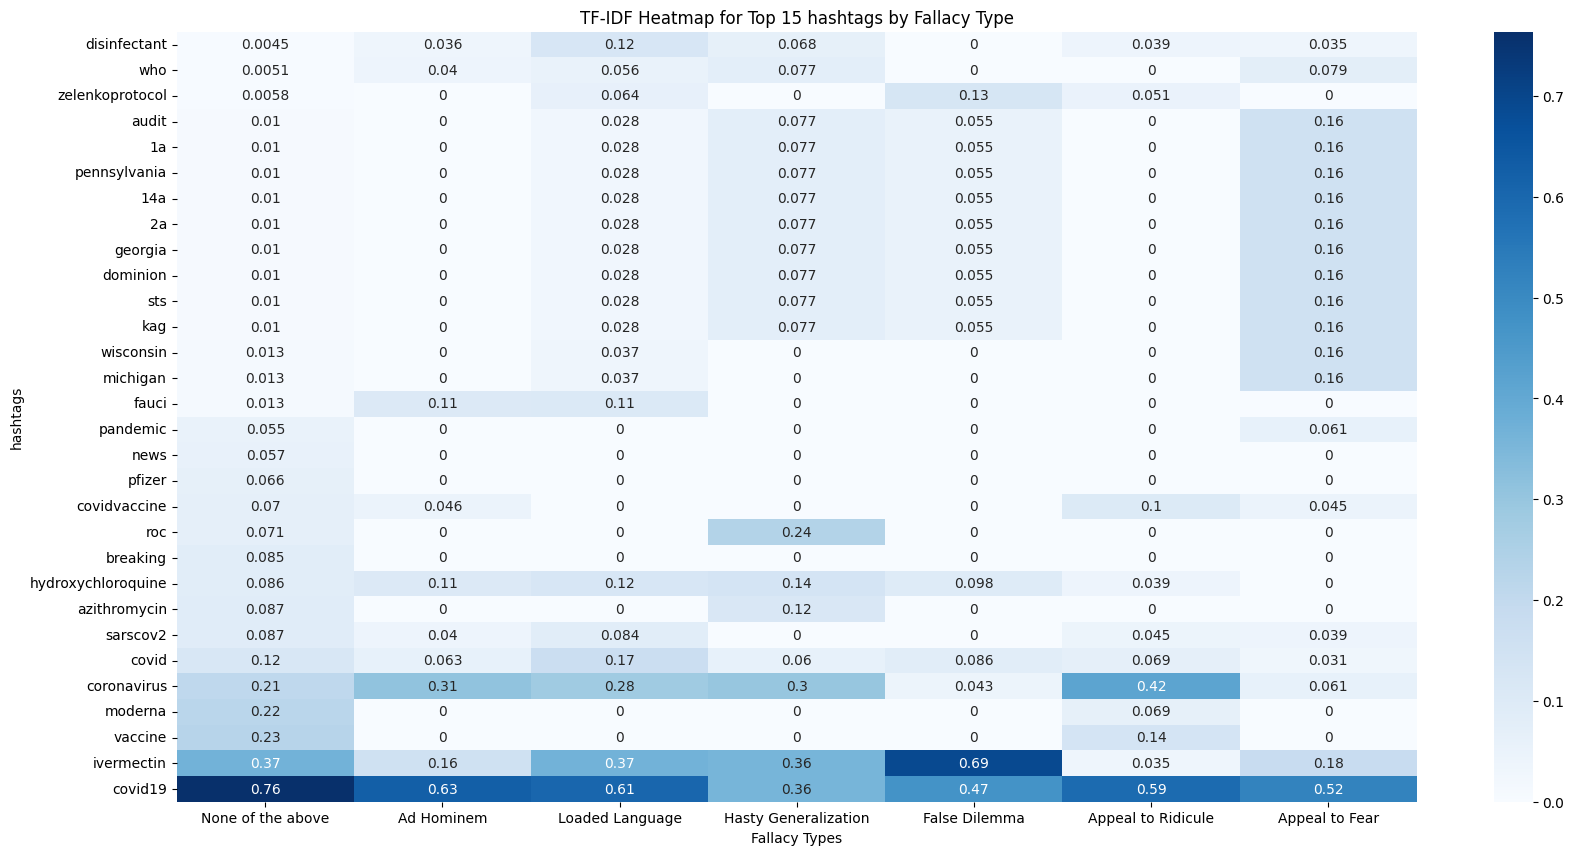

,14a,1a,2019ncov,25thamendmentnow,2a,50swomen,9news,aa,abbott,abhealth,ableg,abpoli,...,wwg1wgaworldwide,yahoofinance,yeg,yqr,ysjaganfailedcm,ysrcpspreadingcorona,yyc,yyccc,zelenkoprotocol,zimbabwe,zinc,zombie
None of the above,0.010244,0.010244,0.018984,0.000000,0.010244,0.018984,0.018984,0.009492,0.009492,0.009492,0.009492,0.009492,...,0.000000,0.009492,0.009492,0.009492,0.000000,0.000000,0.009492,0.009492,0.005847,0.009492,0.023389,0.000000
Ad Hominem,0.000000,0.000000,0.000000,0.053031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046042,0.000000
Loaded Language,0.027846,0.027846,0.000000,0.036614,0.027846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063578,0.000000,0.031789,0.000000
Hasty Generalization,0.077197,0.077197,0.000000,0.000000,0.077197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.118752,0.118752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
False Dilemma,0.055480,0.055480,0.000000,0.000000,0.055480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.126671,0.000000,0.000000,0.000000
Appeal to Ridicule,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.068524,0.068524,0.000000,0.000000,0.050853,0.000000,0.000000,0.082551
Appeal to Fear,0.157853,0.157853,0.000000,0.051889,0.157853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.073132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045051,0.000000


In [19]:
get_tfidf_from_tuples_by_fallacy_type(df = df, column_name = 'hashtags', fallacy_names = fallacy_names, frequency_threshold= 5, top_n = 15)

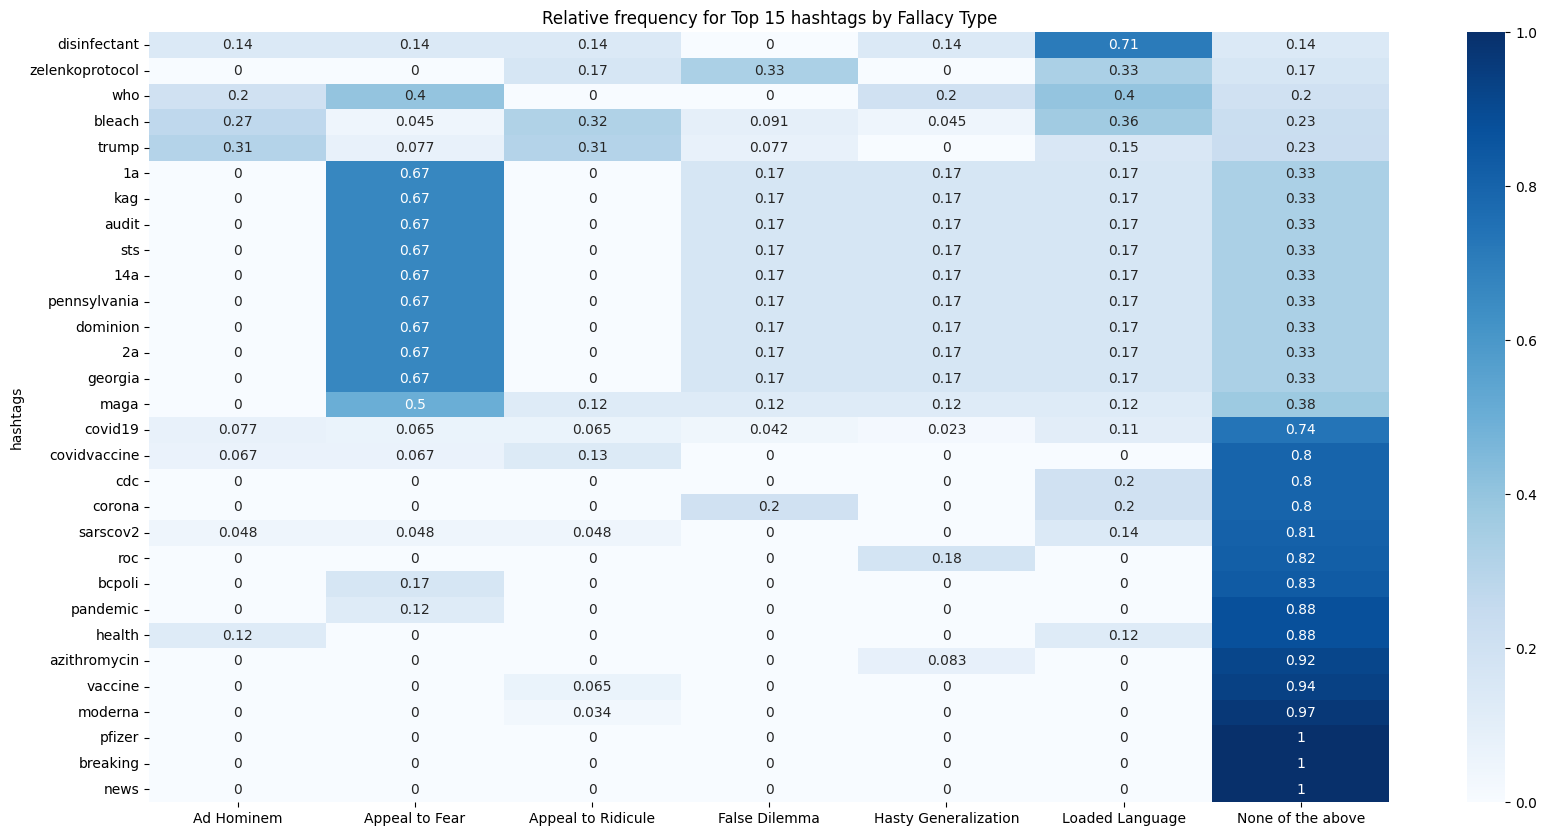

In [20]:
hashtag_absolute_frequency_df, hashtag_relative_frequency_df = get_frequency_matrix_by_fallacy(df = df, column_name = 'hashtags', fallacy_names = fallacy_names, frequency_threshold=5, top_n=15)

## Mentions

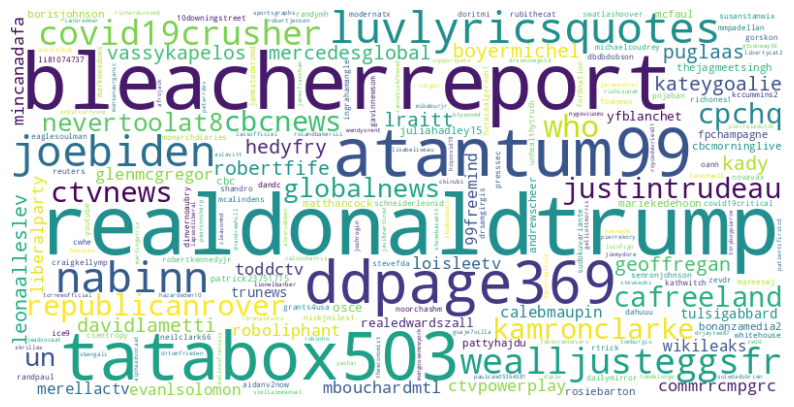

            mentions  frequency
124  realdonaldtrump         96
3     bleacherreport         85
1         tatabox503         61
2          atantum99         61
4          ddpage369         47
5    luvlyricsquotes         44
0             nabinn         43
69          joebiden         43
6    wealljusteggsfr         41
125   covid19crusher         37
17               who         31
7    republicanrover         28
23           ctvnews         28
8       kamronclarke         27
25           cbcnews         27
31     justintrudeau         27
41        cafreeland         27
56             cpchq         27
26        globalnews         26
54                un         26
9       nevertoolat8         25
24      vassykapelos         25
19              kady         24
20     leonaalleslev         24
21            lraitt         24


In [21]:
df['mentions'] = df['mentions'].apply(to_lower_case_and_alnum)

mentions_freq_df = get_frequencies_from_tuples(df, 'mentions', wordcloud=True)

# Get the top most frequent mentions
top_mentions = mentions_freq_df.nlargest(25, 'frequency')
print(top_mentions)

In [22]:
# Get the top most frequent mentions
selected_mentions = list(mentions_freq_df['mentions'][mentions_freq_df['frequency'] > 25])

In [23]:
get_elements_in_top_percentile(freq_df = mentions_freq_df, column_name = 'mentions', percentile = 30)

['realdonaldtrump',
 'bleacherreport',
 'atantum99',
 'tatabox503',
 'ddpage369',
 'luvlyricsquotes',
 'nabinn',
 'joebiden',
 'wealljusteggsfr',
 'covid19crusher',
 'who',
 'republicanrover',
 'ctvnews',
 'justintrudeau',
 'cbcnews',
 'cpchq',
 'cafreeland',
 'kamronclarke',
 'globalnews',
 'un',
 'nevertoolat8',
 'vassykapelos',
 'calebmaupin',
 '99freemind',
 'wikileaks',
 'tulsigabbard',
 'trunews',
 'realedwardszall',
 'osce',
 'merellactv',
 'cbc',
 'yfblanchet',
 'thejagmeetsingh',
 'andrewscheer',
 'rosiebarton',
 'mbouchardmtl',
 'fpchampagne',
 'pattyhajdu',
 'cbcmorninglive',
 'mariekedehoon',
 'bonanzamedia2',
 'mcfaul',
 'loisleetv',
 'evanlsolomon',
 'mincanadafa',
 'hedyfry',
 'kady',
 'leonaalleslev',
 'lraitt']

In [24]:
n = 24
print('# of mentiosn that appear more than', str(n), 'times:    ', len(mentions_freq_df[mentions_freq_df['frequency'] >= n]))
print('Percent of the mentions that they represent:    ', len(mentions_freq_df[mentions_freq_df['frequency'] >= n]) / mentions_freq_df['frequency'].sum())

# of mentiosn that appear more than 24 times:     62
Percent of the mentions that they represent:     0.012085769980506823


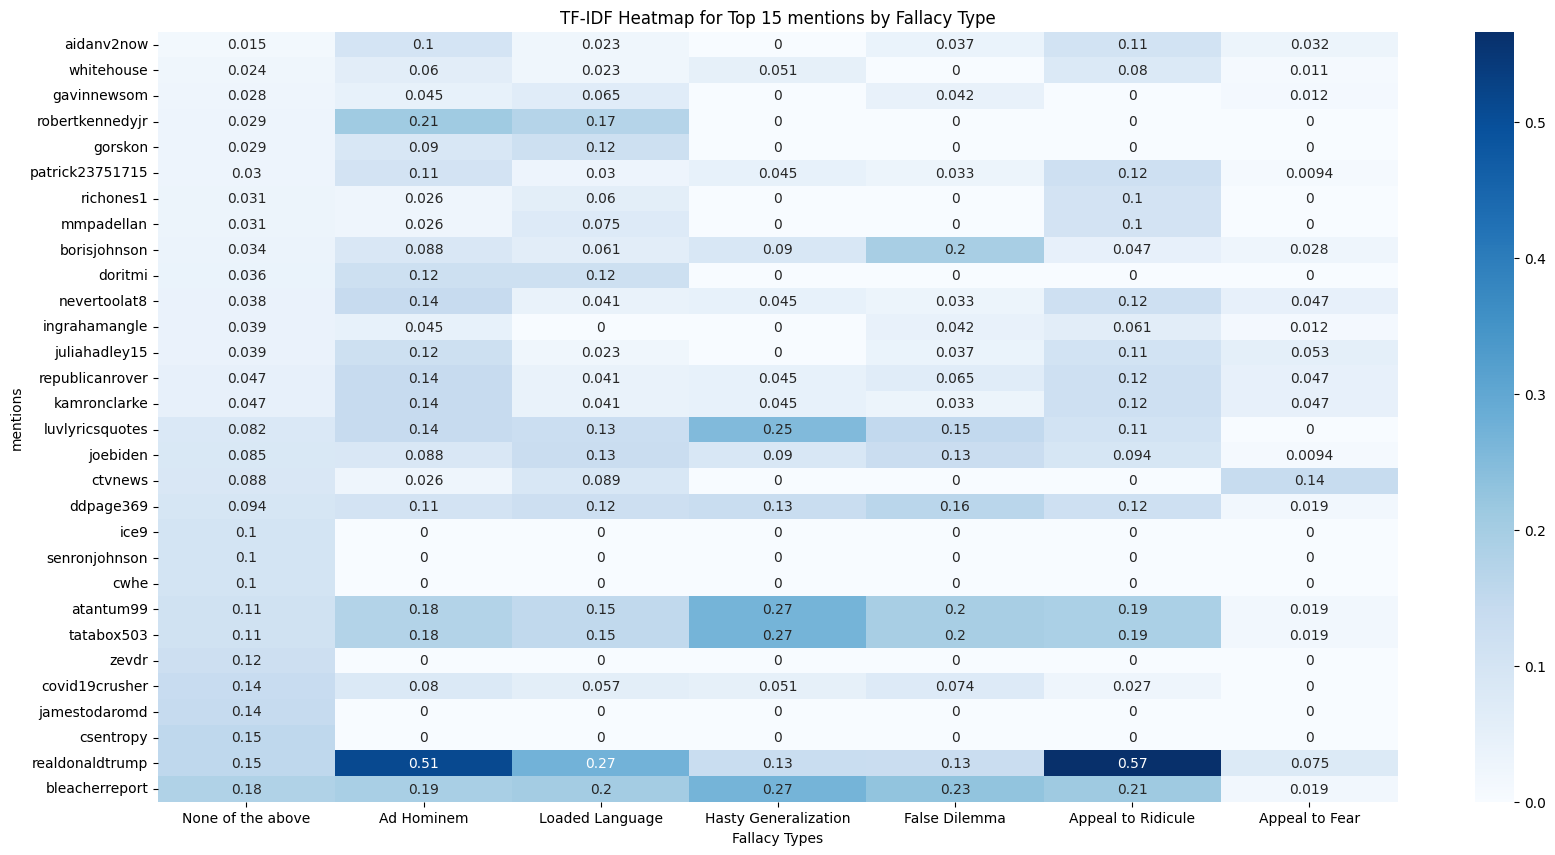

,10downingstreet,10ronaldinho,12fu,13wham,1960dirty,19marino74,1anb1,47gingie,4dgains,99freemind,9newsaus,a102,...,zachbraff,zahoorahmed553,zckukatpally,zdenekvrozina,zedd,zeusbluewave,zevdr,ziggystardad,zimranjacob,zombiemommy,zootza,zoyananas
None of the above,0.049542,0.042339,0.000000,0.020402,0.000000,0.020402,0.00000,0.010201,0.00000,0.062840,0.007238,0.010201,...,0.010201,0.00000,0.010201,0.010201,0.042339,0.000000,0.122412,0.007238,0.000000,0.010201,0.010201,0.020402
Ad Hominem,0.022740,0.000000,0.034980,0.000000,0.034980,0.000000,0.00000,0.000000,0.00000,0.025959,0.029900,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029900,0.000000,0.000000,0.000000,0.000000
Loaded Language,0.026127,0.020095,0.040191,0.000000,0.020095,0.000000,0.00000,0.000000,0.00000,0.089478,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.020095,0.020095,0.000000,0.034354,0.000000,0.000000,0.000000,0.000000
Hasty Generalization,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.088829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
False Dilemma,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.055332,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077984,0.000000,0.000000,0.000000
Appeal to Ridicule,0.030373,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Appeal to Fear,0.048586,0.000000,0.000000,0.000000,0.000000,0.000000,0.02251,0.000000,0.02251,0.138663,0.000000,0.000000,...,0.000000,0.02251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
get_tfidf_from_tuples_by_fallacy_type(df = df, column_name = 'mentions', fallacy_names = fallacy_names, frequency_threshold=10, top_n = 15)

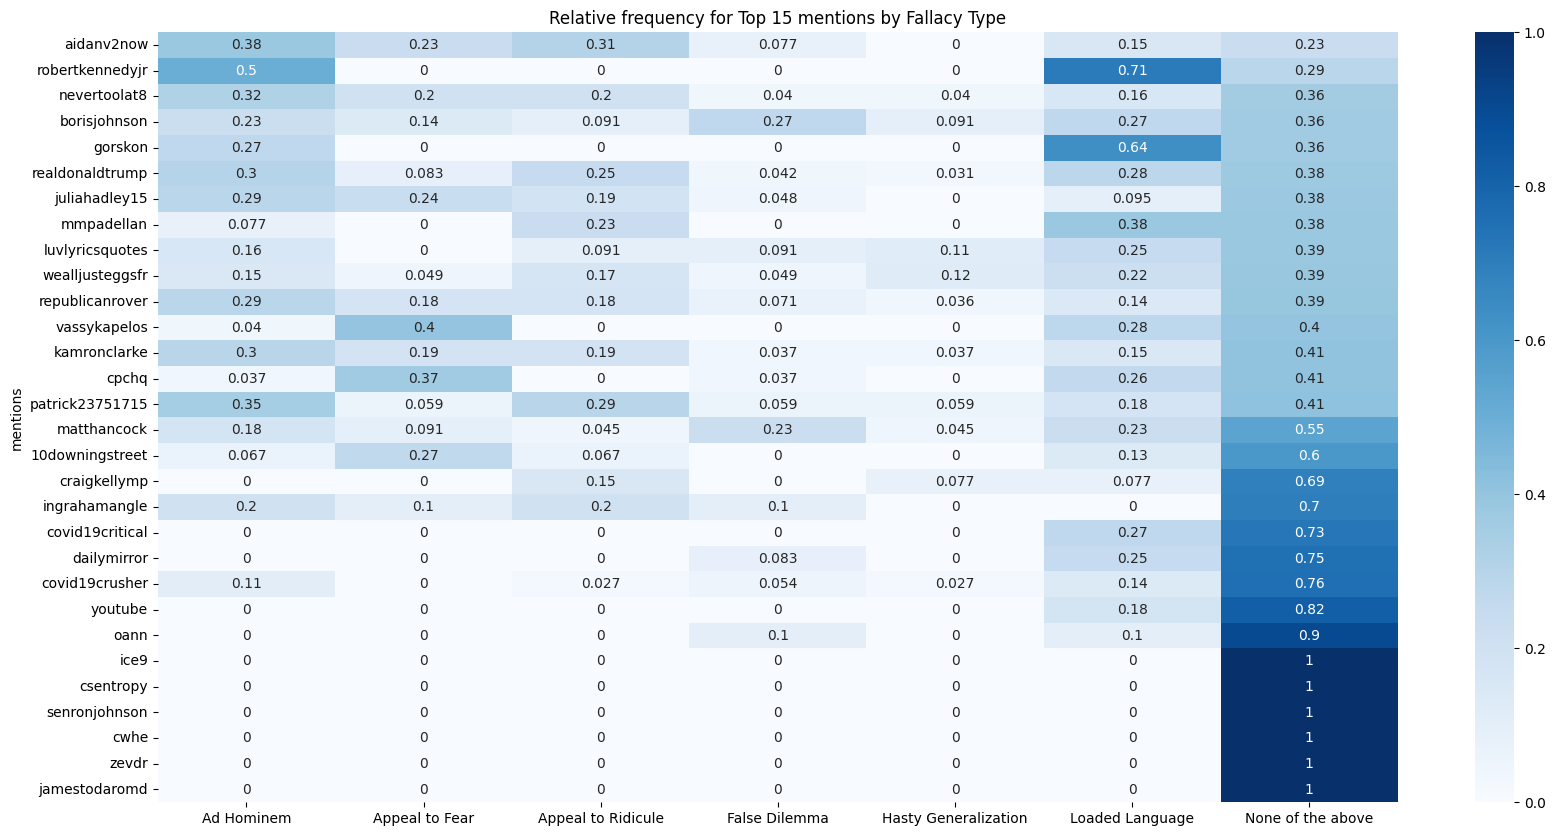

In [26]:
mentions_absolute_frequency_df, mentions_relative_frequency_df = get_frequency_matrix_by_fallacy(df = df, column_name = 'mentions', fallacy_names = fallacy_names, frequency_threshold=10, top_n=15)

## Emojis

In [27]:
import re
import emoji

# Function to extract emojis from text
def extract_emojis(text):
    '''
    Extracts emojis from a text, including compound emojis.

    Args:
    text (str): The text from which to extract emojis.

    Returns:
    tuple: A tuple containing the emojis found in the text.
    '''
    emoji_list = []

    # Find all emojis using emoji's emojize function and regex
    i = 0
    while i < len(text):
        # Check for flags
        if i+1<len(text) and re.match(r'[\U0001F1E6-\U0001F1FF]', text[i]) and re.match(r'[\U0001F1E6-\U0001F1FF]', text[i+1]):
            emoji_list.append(text[i]+text[i+1])
            i += 2

        elif text[i] in emoji.EMOJI_DATA:
            # Check for skin tone modifiers
            if i+1<len(text) and re.match(r'[\U0001F3FB-\U0001F3FF]', text[i+1]):
                if i+2<len(text) and text[i+2] in ['\U00002642','\U00002640','\u2640', '\u2642' ]:
                    emoji_list.append(text[i]+text[i+1]+text[i+2])
                    i += 3
                emoji_list.append(text[i]+text[i+1])
                i += 2
            # Check for gender modifiers
            elif i+1<len(text) and text[i+1] in ['\U00002642','\U00002640','\u2640', '\u2642' ]:
                emoji_list.append(text[i]+text[i+1])
                i += 2
            else:
                emoji_list.append(text[i])
                i += 1
        else:
            i += 1

    return tuple(emoji_list)

# Example usage
print(extract_emojis('👇🏿🤦🏼♀🤷♀Some emojis 🧀🍷🇫🇷'))


('👇🏿', '🤦🏼♀', '🤷♀', '🧀', '🍷', '🇫🇷')


In [28]:
# Extract emojis from the main tweet
df['emojis'] = df['main_tweet'].apply(extract_emojis)

# Get the frequency of emojis
emojis_freq_df = get_frequencies_from_tuples(df, 'emojis', wordcloud=False).sort_values(by='frequency', ascending=False)
emojis_freq_df.head(25)
# notice there is a problem with /n, I could solve that in the future, for the moment is not critical.

,emojis,frequency
0,😂,29
21,👇,25
28,🤔,23
11,🤣,20
49,👍,13
52,👉,12
99,💉,11
17,🇬🇧,10
48,🙄,9
16,🇺🇸,9


In [29]:
selected_emojis = list(emojis_freq_df['emojis'][emojis_freq_df['frequency'] > 5])
# remove \n from the emojis
selected_emojis = [emoji for emoji in selected_emojis if '\n' not in emoji]
selected_emojis

['😂',
 '👇',
 '🤔',
 '🤣',
 '👍',
 '👉',
 '💉',
 '🇬🇧',
 '🙄',
 '🇺🇸',
 '👇🏿',
 '💪',
 '🙏',
 '😊',
 '❤',
 '⤵',
 '😷',
 '🥳',
 '🦠',
 '😭',
 '🤥',
 '😁',
 '➡',
 '😉',
 '🇨🇦']

In [30]:
get_elements_in_top_percentile(freq_df = emojis_freq_df, column_name = 'emojis', percentile = 30)

['😂', '👇', '🤔', '🤣', '👍', '👉', '💉', '🇬🇧', '🙄', '🇺🇸']

/user/machaves/home/Documents/twitter_fallacy_classification/project_venv/lib64/python3.11/site-packages/seaborn/utils.py:84: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from current font.
  fig.canvas.draw()
/user/machaves/home/Documents/twitter_fallacy_classification/project_venv/lib64/python3.11/site-packages/seaborn/utils.py:84: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.draw()
/user/machaves/home/Documents/twitter_fallacy_classification/project_venv/lib64/python3.11/site-packages/seaborn/utils.py:84: UserWarning: Glyph 128073 (\N{WHITE RIGHT POINTING BACKHAND INDEX}) missing from current font.
  fig.canvas.draw()
/user/machaves/home/Documents/twitter_fallacy_classification/project_venv/lib64/python3.11/site-packages/seaborn/utils.py:84: UserWarning: Glyph 128071 (\N{WHITE DOWN POINTING BACKHAND INDEX}) missing from current font.
  fig.canvas.draw()
/user/machaves/home/Documents/twitter_fallacy_classification/pro

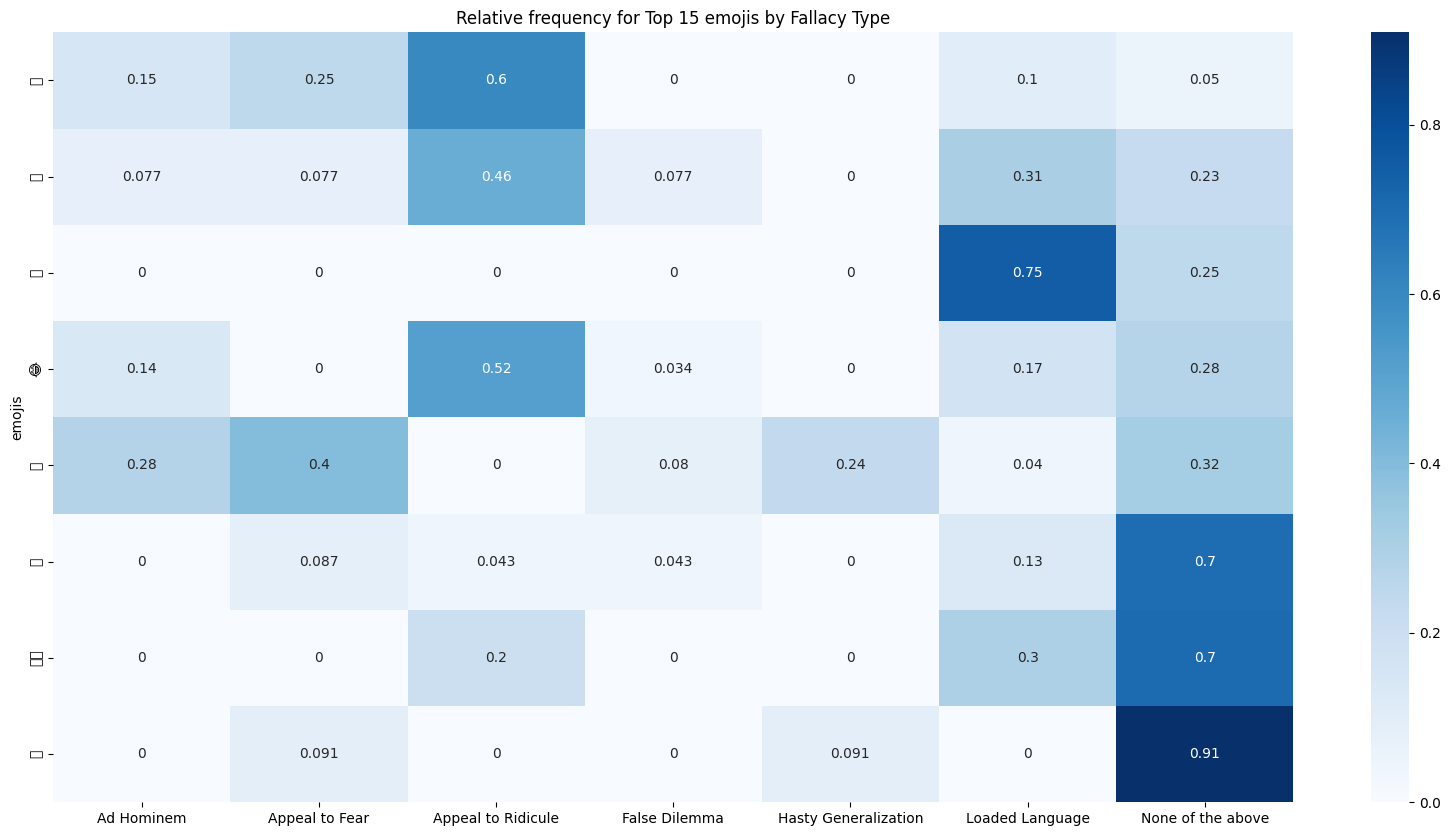

In [31]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

emojis_absolute_frequency_df, emojis_relative_frequency_df = get_frequency_matrix_by_fallacy(df = df, column_name = 'emojis', fallacy_names = fallacy_names, frequency_threshold=10, top_n=15)

In [32]:
most_freq_emojis = list(emojis_freq_df['emojis'][emojis_freq_df['frequency'] > 5])

emojis_relative_frequency_df[emojis_relative_frequency_df.index.isin(most_freq_emojis)] \
    .sort_values(by='None of the above') \
    .round(3)

,Ad Hominem,Appeal to Fear,Appeal to Ridicule,False Dilemma,Hasty Generalization,Loaded Language,None of the above
emojis,,,,,,,
🤥,0.000,0.167,0.000,0.833,0.000,1.000,0.000
🤣,0.150,0.250,0.600,0.000,0.000,0.100,0.050
\n,0.167,0.167,0.167,0.333,0.000,0.333,0.167
😁,0.667,0.000,0.667,0.000,0.167,0.167,0.167
👍,0.077,0.077,0.462,0.077,0.000,0.308,0.231
💪,0.625,0.000,0.000,0.000,0.000,0.375,0.250
👉,0.000,0.000,0.000,0.000,0.000,0.750,0.250
😂,0.138,0.000,0.517,0.034,0.000,0.172,0.276
👇,0.280,0.400,0.000,0.080,0.240,0.040,0.320


## Save selected hashtags, mentions and emojis

In [33]:
selected_elements = {'selected_emojis':selected_emojis, 'selected_hashtags': selected_hashtags, 'selected_mentions': selected_mentions}

with open('results/selected_elements.json', 'w') as json_file:
    json.dump(selected_elements, json_file)
